### **Q-Learning transmit agent**

In [1]:
#!pip install stable_baselines3[extra]
!pip install -U pygame
!pip install gym

In [2]:
import numpy as np
import gym
from gym import spaces
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
from networkx.drawing.nx_pydot import write_dot

import pygame
from sklearn.preprocessing import normalize
import graphviz
from graphviz import Source
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))


pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Global simulation parameters

In [3]:
number_of_iterations = 200000
force_policy_flag = True

#model
MAX_SILENT_TIME = 6
SILENT_THRESHOLD = 3
BATTERY_SIZE = 6
DISCHARGE = 2
MINIMAL_CHARGE = 2
CHARGE = 1

#learning params
GAMMA = 0.99
ALPHA = 0.1
P_LOSS = 0.1
decay_rate = 0.9999

#for rendering
DATA_SIZE = 10

#Env

In [4]:
class transmit_env(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self, battery_size, max_silence_time, time_threshold, minimal_charge, discharge_rate, charge_rate, data_size):
    super(transmit_env,self).__init__()

    #set env parameters
    self.battery_size = battery_size
    self.max_silence_time = max_silence_time
    self.time_threshold = time_threshold
    self.minimal_charge = minimal_charge
    self.discharge_rate = discharge_rate
    self.charge_rate = charge_rate
    self.data_size = data_size

    #reward functions
    'self.r_1 = np.append(np.zeros(self.time_threshold-1),-1*np.ones(self.max_silence_time  - self.time_threshold))'
    self.r_1 = np.append(np.zeros(self.time_threshold-1),-1*np.linspace(0, 8*(self.max_silence_time  - self.time_threshold), self.max_silence_time+1  - self.time_threshold+1))
    

    #action space
    self.action_space = spaces.Discrete(2)

    #state space
    self.state_space = spaces.Tuple((spaces.Discrete(self.max_silence_time), spaces.Discrete(self.battery_size)))
    self.initial_energy = self.battery_size
    self.initial_silence = 0
    self.initial_state = [self.initial_energy-1 , self.initial_silence]
    self.state = self.initial_state
    self.new_state = self.initial_state

    #Screen size of data
    self.screen = pygame.display.set_mode((data_size * 100 , 100))


  def time_step(self, action):
    #take action accoring to policy (epsilon-greedy) and get reward and next state
    #######################################################
    current_energy, silent_time = self.state
    reward = 0

    #draw channel ocupency
    occupied =  self.get_channel_occupency(P_LOSS)

    if action == 1:      #transmit
      if occupied:
        pass
        #collision
        if current_energy < self.minimal_charge:
          raise ValueError('No charge left, can not transmit')
        else:
          current_energy -= self.discharge_rate
        silent_time += 1
      else:
        #clean transmit
        if current_energy < self.minimal_charge:
          raise ValueError('No charge left, can not transmit')
        else:
          current_energy -= self.discharge_rate
        silent_time = 0
        reward += 1
    
    else:      #wait
      if current_energy < self.battery_size -1:
        current_energy += self.charge_rate
      silent_time += 1
    
    if silent_time > self.max_silence_time -1:
      silent_time = self.max_silence_time -1
    
    reward += self.get_reward(current_energy, silent_time)
    
    #compose new state
    new_state = [current_energy, silent_time]

    return new_state, reward, occupied

  def reset():################################################## EPISODIC NOT IMPLEMENTED - PURE ONLINE
    return

  def render(self, data):
    output.clear()
    for i in range(self.data_size):
      if data[i] == 3: #collision
        pygame.draw.rect(self.screen, (255,0,0), pygame.Rect( i*100, 0 , 100, 100))
      elif data[i] == 2: #avoided
        pygame.draw.rect(self.screen, (0,255,0), pygame.Rect( i*100, 0 , 100, 100))
      elif data[i] == 1: #clean
        pygame.draw.rect(self.screen, (0,0,255), pygame.Rect( i*100, 0 , 100, 100))
      elif data[i] == 0: #wasted
        pygame.draw.rect(self.screen, (200,200,200), pygame.Rect( i*100, 0 , 100, 100))
    pygame.display.flip()
    #convert image so it can be displayed in OpenCV
    view = pygame.surfarray.array3d(self.screen)

    #  convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    # Using cv2.putText() method
    for i in range(self.data_size):
      if data[i] == 3: #collision
        img_bgr = cv2.putText(img_bgr, "collision", (i*100+20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA) ###################################TEXT?
        #pygame.draw.rect(self.screen, (255,0,0), pygame.Rect( i*100, 0 , 100, 100))
      elif data[i] == 2: #avoided
        img_bgr = cv2.putText(img_bgr, "avoided", (i*100+20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      elif data[i] == 1: #clean
        img_bgr = cv2.putText(img_bgr, "clean", (i*100+20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      elif data[i] == 0: #wasted
        img_bgr = cv2.putText(img_bgr, "wasted", (i*100+20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    #

    #Display image, clear cell every 0.5 seconds
    cv2_imshow(img_bgr)

    #time.sleep(0.1)

  def get_reward(self, energy, silenct_time):
    reward = self.r_1[silenct_time] #+ self.r_3[energy]
    return reward

  def get_channel_occupency(self, loss):
    event = np.random.uniform(0,1,1)
    return event < loss

#Agent

In [5]:
class Q_transmit_agent():
  def __init__(self, alpha, gamma, battery_size , max_silence_time, data_size):
    self.alpha = alpha#################swap to alpha table
    self.gamma = gamma
    self.data_size = data_size
    self.number_of_actions = 2
    self.Q = np.zeros(shape=(battery_size, max_silence_time, self.number_of_actions))
    self.state_visits = np.zeros(shape=(battery_size, max_silence_time))
    self.error = np.zeros(shape=(battery_size, max_silence_time, self.number_of_actions))

  def choose_action(self, state, epsilon):
    #decompose state
    current_energy, slient_time = state
    #print('current_energy',current_energy)
    #print('slient_time',slient_time)

    # Explore ?
    if np.random.uniform(size=1) < epsilon :
      action =  np.random.randint(2)

    #Exploite - Choose the current best action
    else:
      action = np.argmax(self.Q[current_energy, slient_time]) #Take the action that has the highest predicted Q value (0, 1)
    
    #Dont have energy for transmision
    if current_energy < MINIMAL_CHARGE:
      action = 0
    return action

  def Q_learn(self, state, reward, action, new_state):
    #decompose state
    current_energy, slient_time = state
    #q_index = [current_energy,slient_time, action]
    self.state_visits[current_energy, slient_time] += 1

    #decompose new state
    next_energy, next_silence = new_state
    #next_best_q_value_index = np.argmax(self.Q[next_energy, next_silence,:])
    #new_Q = reward + self.gamma*self.Q[next_energy, next_silence, next_best_q_value_index]
    #error = new_Q - self.Q[q_index]
    #self.Q[q_index] += self.alpha * error #################swap to alpha table
    self.error[current_energy,slient_time, action] = reward +self.gamma*(np.max(self.Q[next_energy, next_silence,:])) - self.Q[current_energy,slient_time, np.argmax(self.Q[current_energy,slient_time, action])]
    self.Q[current_energy,slient_time, action] = self.Q[current_energy,slient_time, action] + self.alpha*(reward +self.gamma*(np.max(self.Q[next_energy, next_silence,:]))-self.Q[current_energy,slient_time, action])
    return

  def step(self, state, reward, action, new_state, epsilon):
    self.Q_learn(state, reward, action, new_state)
    action = self.choose_action(new_state, epsilon)
    return action

#Simulation

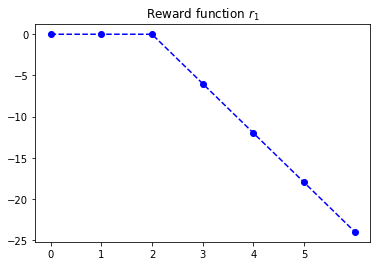

r_1 array:  [0 0 -0 -6 -12 -18 -24]
0
100000
2.0590933617707698e-09


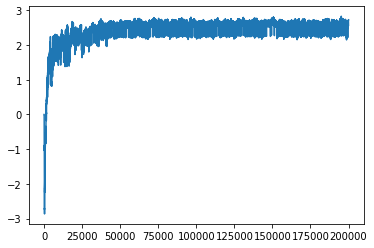

In [6]:
'''run realtime experiences'''
T = np.zeros(shape = (BATTERY_SIZE*MAX_SILENT_TIME,MAX_SILENT_TIME*BATTERY_SIZE)) #transition matrix
#initialize environment 
env = transmit_env(BATTERY_SIZE, MAX_SILENT_TIME, SILENT_THRESHOLD, MINIMAL_CHARGE, DISCHARGE, CHARGE, 10)

#plot reward function in use
plt.plot(range(len(env.r_1)),env.r_1 , 'o--' , color = 'blue')
plt.xticks(range(env.max_silence_time))
plt.title('Reward function $r_1$')
plt.show()
print('r_1 array: ' , env.r_1)

#init agent
agent = Q_transmit_agent(ALPHA, GAMMA, BATTERY_SIZE, MAX_SILENT_TIME , DATA_SIZE)
initial_energy = BATTERY_SIZE #full battery

state = env.initial_state
epsilon = 1
data = np.zeros(env.data_size)
errors = []
action = agent.choose_action(state,epsilon)
for i in range(number_of_iterations):
  env.state = env.new_state
  new_state, reward, occupied = env.time_step(action)
  errors.append(np.mean(agent.error))
  env.new_state = new_state
  if occupied and action:
    data = np.append(data, 3) #collision
  elif occupied and (not action):
    data = np.append(data,2) #avoided
  elif action and (not occupied):
    data = np.append(data,1) #Clean
  else:
    data = np.append(data,0) #wasted
  data = np.delete(data, 0)

  if i%100000 == 0:
    print(i)
  #print(env.state, env,new_state)
  action = agent.step(env.state, reward, action, env.new_state, epsilon)
  
  #decompose state
  current_energy, slient_time = env.state
  #decompose new state
  next_energy, next_silence = env.new_state
  #print(current_energy, slient_time,'->',next_energy, next_silence , '~~~', current_energy*(BATTERY_SIZE-1)+slient_time, next_energy*(BATTERY_SIZE-1)+next_silence)
  T[current_energy*(BATTERY_SIZE)+slient_time, next_energy*(BATTERY_SIZE)+next_silence]+=1
  epsilon = epsilon*decay_rate
  #collect state transitions in T
  #print(current_energy,slient_time , '->' ,next_energy,next_silence)
  #print(current_energy*(BATTERY_SIZE)+slient_time , '---->' ,next_energy*(BATTERY_SIZE)+next_silence)
 # env.render(data)
print(epsilon)
plt.plot(errors)

In [7]:
'''
print(normalize(T, axis=1, norm='l1'))
for i in range(T.shape[0]):
  for j in range(T.shape[1]):
    if T[i,j] != 0: print(i,j)
'''

"\nprint(normalize(T, axis=1, norm='l1'))\nfor i in range(T.shape[0]):\n  for j in range(T.shape[1]):\n    if T[i,j] != 0: print(i,j)\n"

In [8]:
#print(agent.state_visits)
#print(agent.Q)

##Get resulting policy

In [9]:
def get_policy():
  print('x - time, y - energy')
  policy = np.zeros(shape=(agent.Q.shape[0],agent.Q.shape[1]))
  Q1 = np.zeros(shape=(agent.Q.shape[0],agent.Q.shape[1]))
  Q2 = np.zeros(shape=(agent.Q.shape[0],agent.Q.shape[1]))
  for energy in range(agent.Q.shape[0]):
    for time in range(agent.Q.shape[1]):
      if force_policy_flag == True:
        if energy < MINIMAL_CHARGE:
          policy[energy,time] = 0 
        else:
          policy[energy,time] = np.argmax(agent.Q[energy,time,:])
      Q1[energy,time] = agent.Q[energy,time,0]
      Q2[energy,time] = agent.Q[energy,time,1]
  print(policy)
  #print(Q1)
  #print(Q2)
  return policy
policy = get_policy()

x - time, y - energy
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]]


In [10]:
def get_state_value(policy):
  state_value = np.zeros(shape=(agent.Q.shape[0],agent.Q.shape[1]))
  for energy in range(agent.Q.shape[0]):
    for time in range(agent.Q.shape[1]):
      state_value[energy,time] = agent.Q[energy,time,int(policy[energy,time])]

  return state_value
state_value = get_state_value(policy)
print(state_value)

[[4.13 0 -6 -12 -3.42 -18]
 [3.17 4.47 -4.39 -10.2 -18.3 -19.2]
 [4.3 3.81 4.8 2.05 2.8 1.8]
 [4.6 3.97 0.301 3.41 1.33 2.71]
 [0 4.9 4.14 3.92 4.49 1.64]
 [0 0 4.31 3.73 2.27 4.64]]


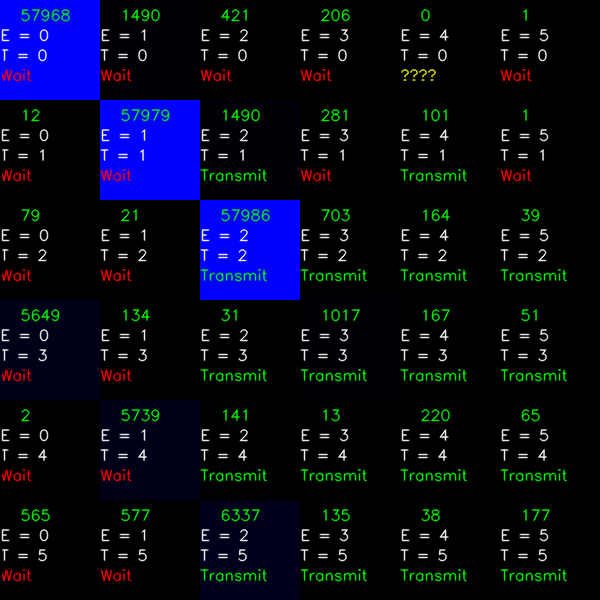

In [11]:
def render_policy_visits_table(table,colors_table):
  screen = pygame.display.set_mode((table.shape[0] * 100 , table.shape[1]*100))
  color = colors_table/np.max(colors_table)*255

  for i in range(table.shape[0]):
    for j in range(table.shape[1]):

      pygame.draw.rect(screen, int(color[i,j]), pygame.Rect(i*100, j*100, 100, 100))
  pygame.display.flip()

  #convert image so it can be displayed in OpenCV
  view = pygame.surfarray.array3d(screen)

  #  convert from (width, height, channel) to (height, width, channel)
  view = view.transpose([1, 0, 2])

  #  convert from rgb to bgr
  img = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  for i in range(table.shape[0]):
    for j in range(table.shape[1]):
      img = cv2.putText(img, "%d " %colors_table[i,j] , (i*100+20,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
      img = cv2.putText(img, "E = %d" % i, (i*100,j*100+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      img = cv2.putText(img, "T = %d" % j, (i*100,j*100+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      if colors_table[i,j] == 0:
        img = cv2.putText(img, "????", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
      else:
        if table[i,j] == 1:
          img = cv2.putText(img, "Transmit", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        elif table[i,j] == 0:
          img = cv2.putText(img, "Wait", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

           # img_bgr = cv2.putText(img_bgr, "%.3f" % value[i,j], (i*100,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
  #else:
  #  img = cv2.putText(img_bgr, "Wait", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
  cv2_imshow(img)

render_policy_visits_table(policy,agent.state_visits)


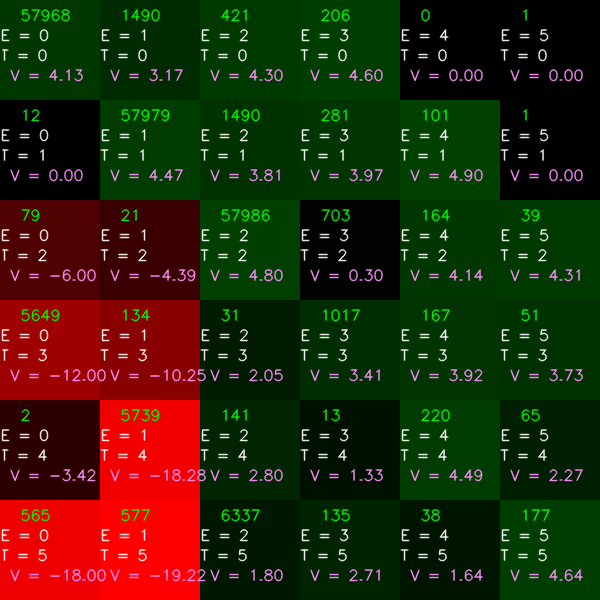

state value, color by value


In [12]:
def render_state_value_visits_table(table,colors_table):
  screen = pygame.display.set_mode((table.shape[0] * 100 , table.shape[1]*100))
  color = (table)/np.max(np.abs(table))*255
  for i in range(table.shape[0]):
    for j in range(table.shape[1]):
      if int(color[i,j])<0:
          pygame.draw.rect(screen,  (-int(color[i,j]), 0, 0), pygame.Rect(i*100, j*100, 100, 100))
      else:
          pygame.draw.rect(screen, (0, int(color[i,j]), 0), pygame.Rect(i*100, j*100, 100, 100))
  pygame.display.flip()

  #convert image so it can be displayed in OpenCV
  view = pygame.surfarray.array3d(screen)

  #  convert from (width, height, channel) to (height, width, channel)
  view = view.transpose([1, 0, 2])

  #  convert from rgb to bgr
  img = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  for i in range(table.shape[0]):
    for j in range(table.shape[1]):
      img = cv2.putText(img, "%d " %colors_table[i,j] , (i*100+20,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
      img = cv2.putText(img, "E = %d" % i, (i*100,j*100+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      img = cv2.putText(img, "T = %d" % j, (i*100,j*100+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

      img = cv2.putText(img, "V = %.2f" % table[i,j], (i*100+10,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 147, 255), 1, cv2.LINE_AA)

  cv2_imshow(img)

render_state_value_visits_table(state_value,agent.state_visits)
print('state value, color by value')

Difference Q1 - Q2 (wait - transmit)


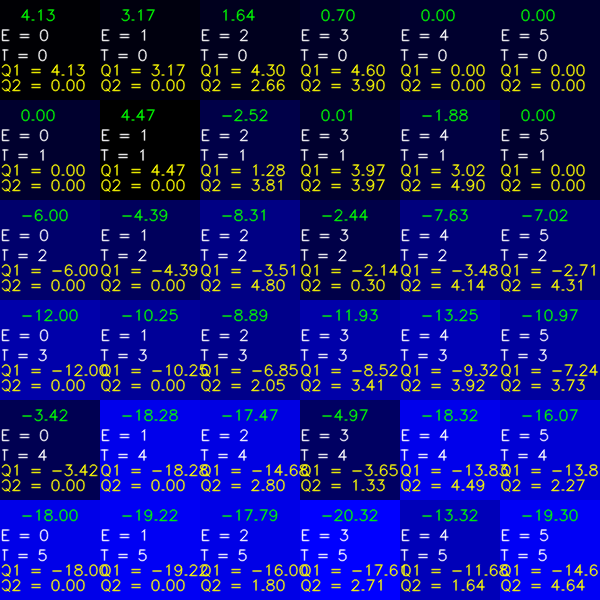

In [13]:
def render_Q_diffs(Q1,Q2):
  screen = pygame.display.set_mode((Q1.shape[0] * 100 , Q1.shape[1]*100))
  diff = (Q1 - Q2)
  diff_pos = diff-np.min(diff)# shift to posetive
  color = diff_pos/np.max(diff_pos)*255

  print('Difference Q1 - Q2 (wait - transmit)')
  for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):

      pygame.draw.rect(screen, 255-int(color[i,j]), pygame.Rect(i*100, j*100, 100, 100))
  pygame.display.flip()

  #convert image so it can be displayed in OpenCV
  view = pygame.surfarray.array3d(screen)

  #  convert from (width, height, channel) to (height, width, channel)
  view = view.transpose([1, 0, 2])

  #  convert from rgb to bgr
  img = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

  for i in range(Q1.shape[0]):
    for j in range(Q2.shape[1]):
      img = cv2.putText(img, "%.2f " %diff[i,j] , (i*100+20,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
      img = cv2.putText(img, "E = %d" % i, (i*100,j*100+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      img = cv2.putText(img, "T = %d" % j, (i*100,j*100+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
      img = cv2.putText(img, "Q1 = %.2f" %Q1[i,j], (i*100,j*100+75), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
      img = cv2.putText(img, "Q2 = %.2f" %Q2[i,j], (i*100,j*100+90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)


           # img_bgr = cv2.putText(img_bgr, "%.3f" % value[i,j], (i*100,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
  #else:
  #  img = cv2.putText(img_bgr, "Wait", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
  cv2_imshow(img)

render_Q_diffs(agent.Q[:,:,0],agent.Q[:,:,1])

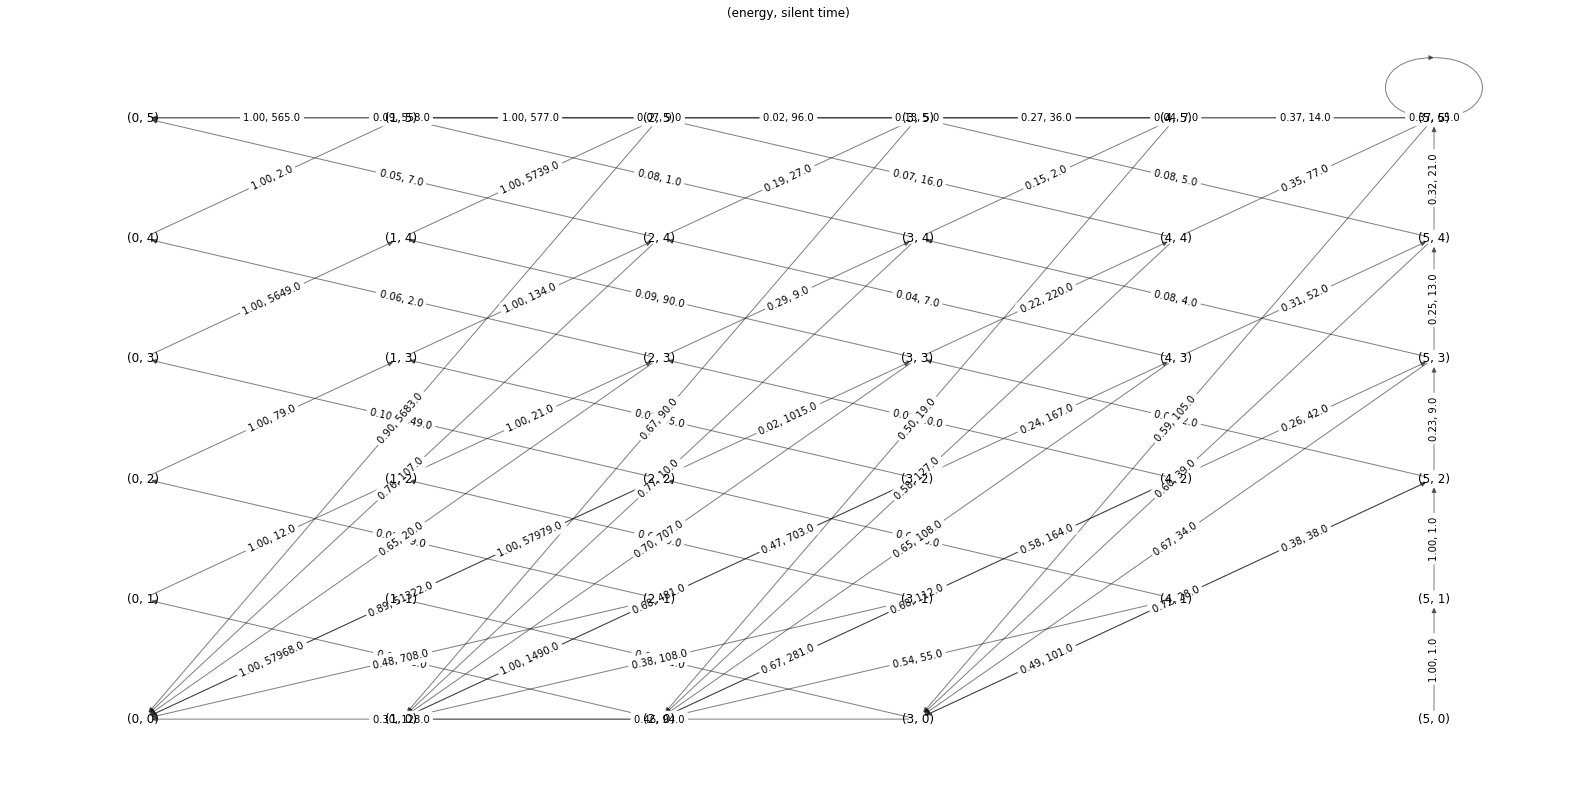

In [14]:
states = []
for i in range(agent.Q.shape[0]):
  for j in range(agent.Q.shape[1]):
    states.append((i,j))


G = nx.MultiDiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        rate = normalize(T, axis=1, norm='l1')[i][j]
        if rate > 0:
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="{:.02f}, {d}".format(rate, d =T[i][j]))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}, {d}".format(rate, d =T[i][j])


plt.figure(figsize=(28,14))
node_size = 200
pos = {state:list(state) for state in states}
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.title('(energy, silent time)')
plt.axis('off');
write_dot(G, 'mc.dot')

In [15]:
s = Source.from_file('mc.dot')
s.view()


'mc.dot.pdf'

##**Agent evaluation $\epsilon = 0$**

In [16]:
#No exploration
epsilon = 0
num_of_eval_iner = 1000
Teval = np.zeros(shape = (BATTERY_SIZE*MAX_SILENT_TIME,MAX_SILENT_TIME*BATTERY_SIZE)) #transition matrix

for i in range(num_of_eval_iner):
  env.state = env.new_state
  new_state, reward, occupied = env.time_step(action)
  env.new_state = new_state
  if occupied and action:
    data = np.append(data, 3) #collision
  elif occupied and (not action):
    data = np.append(data,2) #avoided
  elif action and (not occupied):
    data = np.append(data,1) #Clean
  else:
    data = np.append(data,0) #wasted
  data = np.delete(data, 0)
  
  #print(env.state, env,new_state)
  action = agent.step(env.state, reward, action, env.new_state, epsilon)
  
  #decompose state
  current_energy, slient_time = env.state
  #decompose new state
  next_energy, next_silence = env.new_state
  #print(current_energy, slient_time,'->',next_energy, next_silence , '~~~', current_energy*(BATTERY_SIZE-1)+slient_time, next_energy*(BATTERY_SIZE-1)+next_silence)
  Teval[current_energy*(BATTERY_SIZE)+slient_time, next_energy*(BATTERY_SIZE)+next_silence]+=1


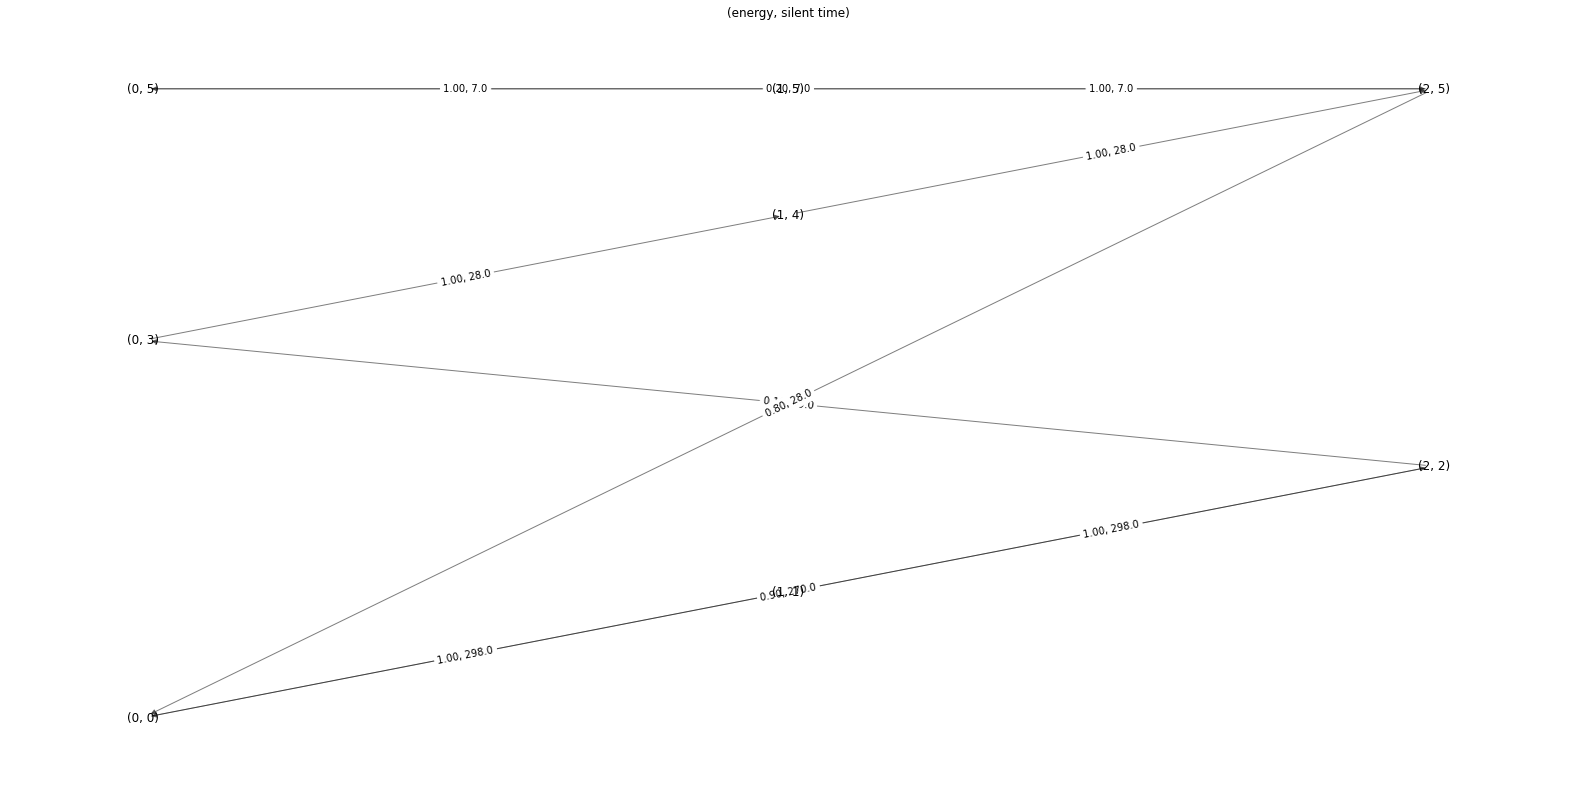

In [17]:
states = []
for i in range(agent.Q.shape[0]):
  for j in range(agent.Q.shape[1]):
    states.append((i,j))


G = nx.MultiDiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        rate = normalize(Teval, axis=1, norm='l1')[i][j]
        if rate > 0:
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="{:.02f}, {d}".format(rate, d =Teval[i][j]))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}, {d}".format(rate, d =Teval[i][j])


plt.figure(figsize=(28,14))
node_size = 200
pos = {state:list(state) for state in states}
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.title('(energy, silent time)')
plt.axis('off');
write_dot(G, 'eval.dot')

In [18]:
s = Source.from_file('eval.dot')
s.view()


'eval.dot.pdf'

##Deploy agent
